In [1]:
import numpy as np

# # Read 8-mer nucleotide composition
k_mer = np.load("k_mer.npy")
# Read sequence order correlated factors
theta_list = np.load("theta_list.npy")
# Concatenate the 8-mer nucleotide composition and sequence order correlated factors
features = np.column_stack((k_mer,theta_list)) 
print(features.shape)

(644, 65550)


In [2]:
# Read labels
target = np.load("target.npy")
print(target.shape)

(644,)


In [3]:
# When the value of i-th feature for all lncRNA sequences are zero, we will delete this feature.
list_delete = []
for i in range(65536):
    if sum(features[:,i])==0:
        list_delete.append(i)
features_new = np.delete(features, list_delete, axis=1)
print(features_new.shape)

(644, 64723)


In [4]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

# Apply the ANOVA to obtain the optimal feature subset
selector = SelectKBest(f_classif, k=11220)
selector.fit(features_new, target)
features_selected = selector.transform(features_new)
print(features_selected.shape)

(644, 11220)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

In [6]:
# Binarize the output
y = label_binarize(target, classes=[0, 1, 2, 3])
n_classes = y.shape[1]
# X represets the features which are selected
X = features_selected

pipe = Pipeline([("scaler", MinMaxScaler()), 
                 ("svm",SVC(C=256, gamma=0.0001220703125, decision_function_shape="ovo",kernel="rbf",probability=True))])

In [7]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(pipe)
y_score = []
loo = LeaveOneOut()
for train, test in loo.split(X,y):
    # Obtain the "certainty score" of a lncRNA sequence for each class
    y_score_i = classifier.fit(X[train], y[train]).decision_function(X[test])
    y_score.append(y_score_i.ravel().tolist())
y_score = np.array(y_score)

In [8]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [9]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

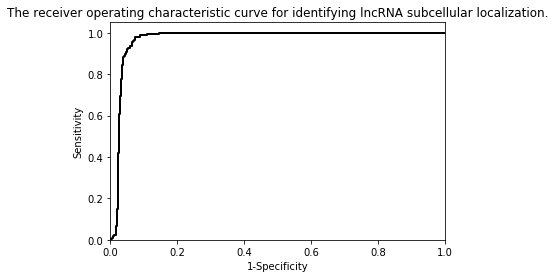

In [10]:
# Plot the ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='black', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
ax = plt.gca()

plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.title('The receiver operating characteristic curve for identifying lncRNA subcellular localization.')
plt.show()

In [11]:
# AUC value
print(roc_auc["micro"])

0.969541266412047
